<a href="https://colab.research.google.com/github/IllgamhoDuck/Quantum-Circuit-Optimization-with-Deep-learning/blob/master/Random_quantum_circuit_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random quantum circuit Generator
**Circuit auto generator and how to encode**

This is a page that introduces how to use a random quantum circuit generator. This will be used to generate the dataset of quantum circuits.

### Setting environment
- package install
- package import

In [0]:
!pip install --quiet qiskit nxpd

In [0]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.circuit.random.utils import random_circuit

 
 ## Random Circuit 
 **Generate random circuit of arbitrary size of form**

 ```def random_circuit(n_qubits, depth, max_operands=3, measure=False, conditional=False, reset=False, seed=None)```

    - n_qubits (int): number of quantum wires
    - depth (int): layers of operations (i.e. critical path length)
    - max_operands (int): maximum operands of each gate (between 1 and 3)
    - measure (bool): if True, measure all qubits at the end
    - conditional (bool): if True, insert middle measurements and conditionals
    - reset (bool): if True, insert middle resets
    - seed (int): sets random seed (optional)


**URL**

    - https://github.com/Qiskit/qiskit-terra/blob/master/qiskit/circuit/random/utils.py
    - https://github.com/Qiskit/qiskit-terra/blob/2582fae6a3cf020f5715d8ed58b492eb91a7604d/tools/random_qasm_generator.py

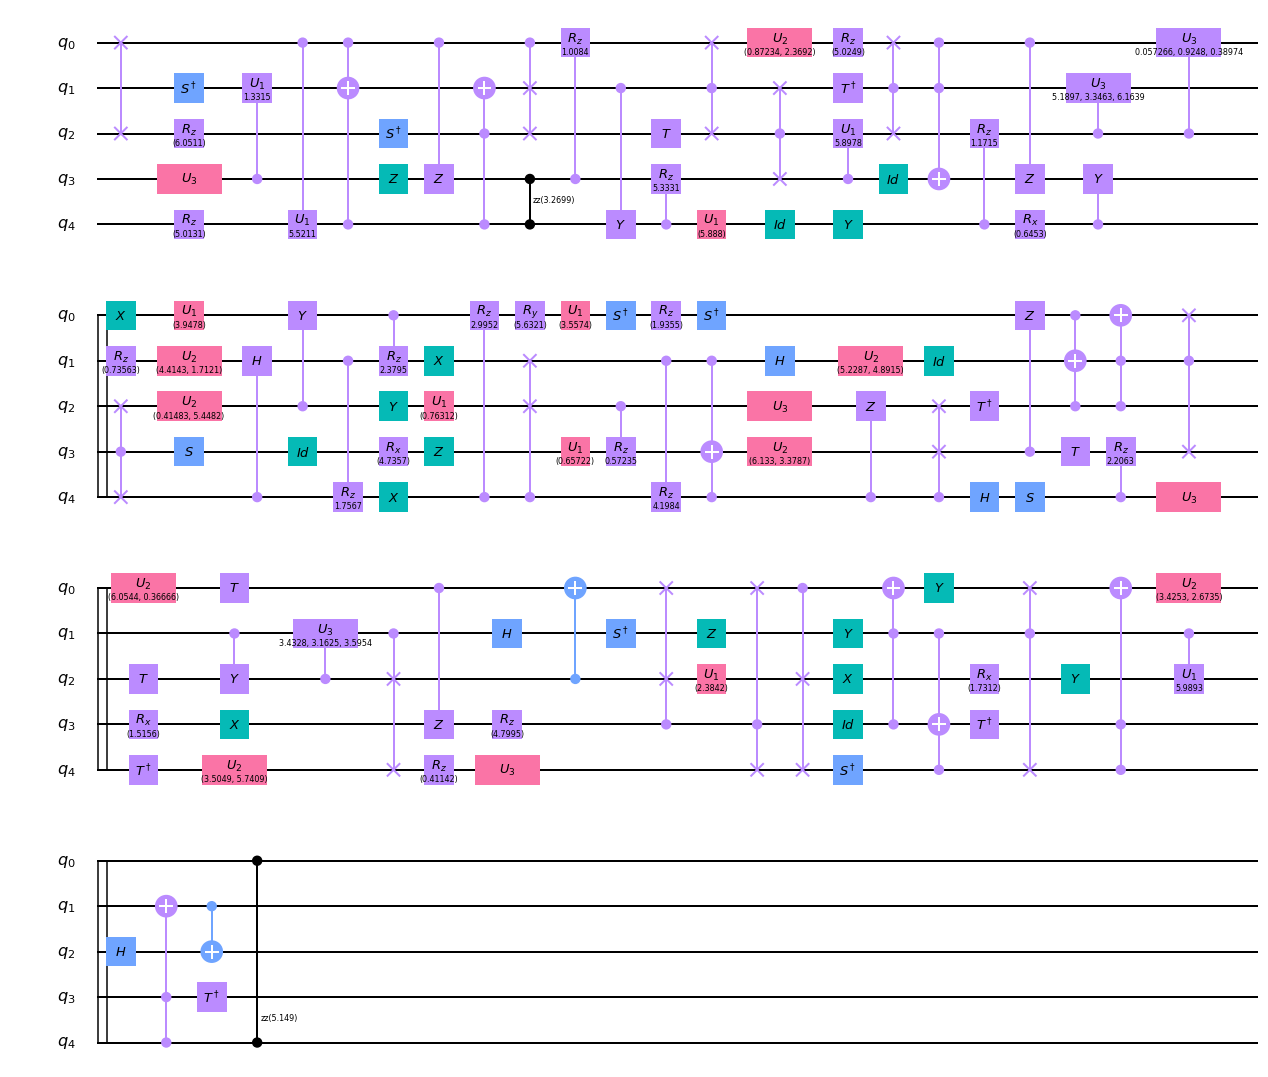

In [0]:
qc = random_circuit(5, 40)
qc.draw(output='mpl')

## Unroll
**Unroll the quantum circuit to basis gates**


gates =  OrderedDict([('u1', 244), ('cx', 215), ('u2', 70), ('u3', 25), ('id', 5)])
depth =  320


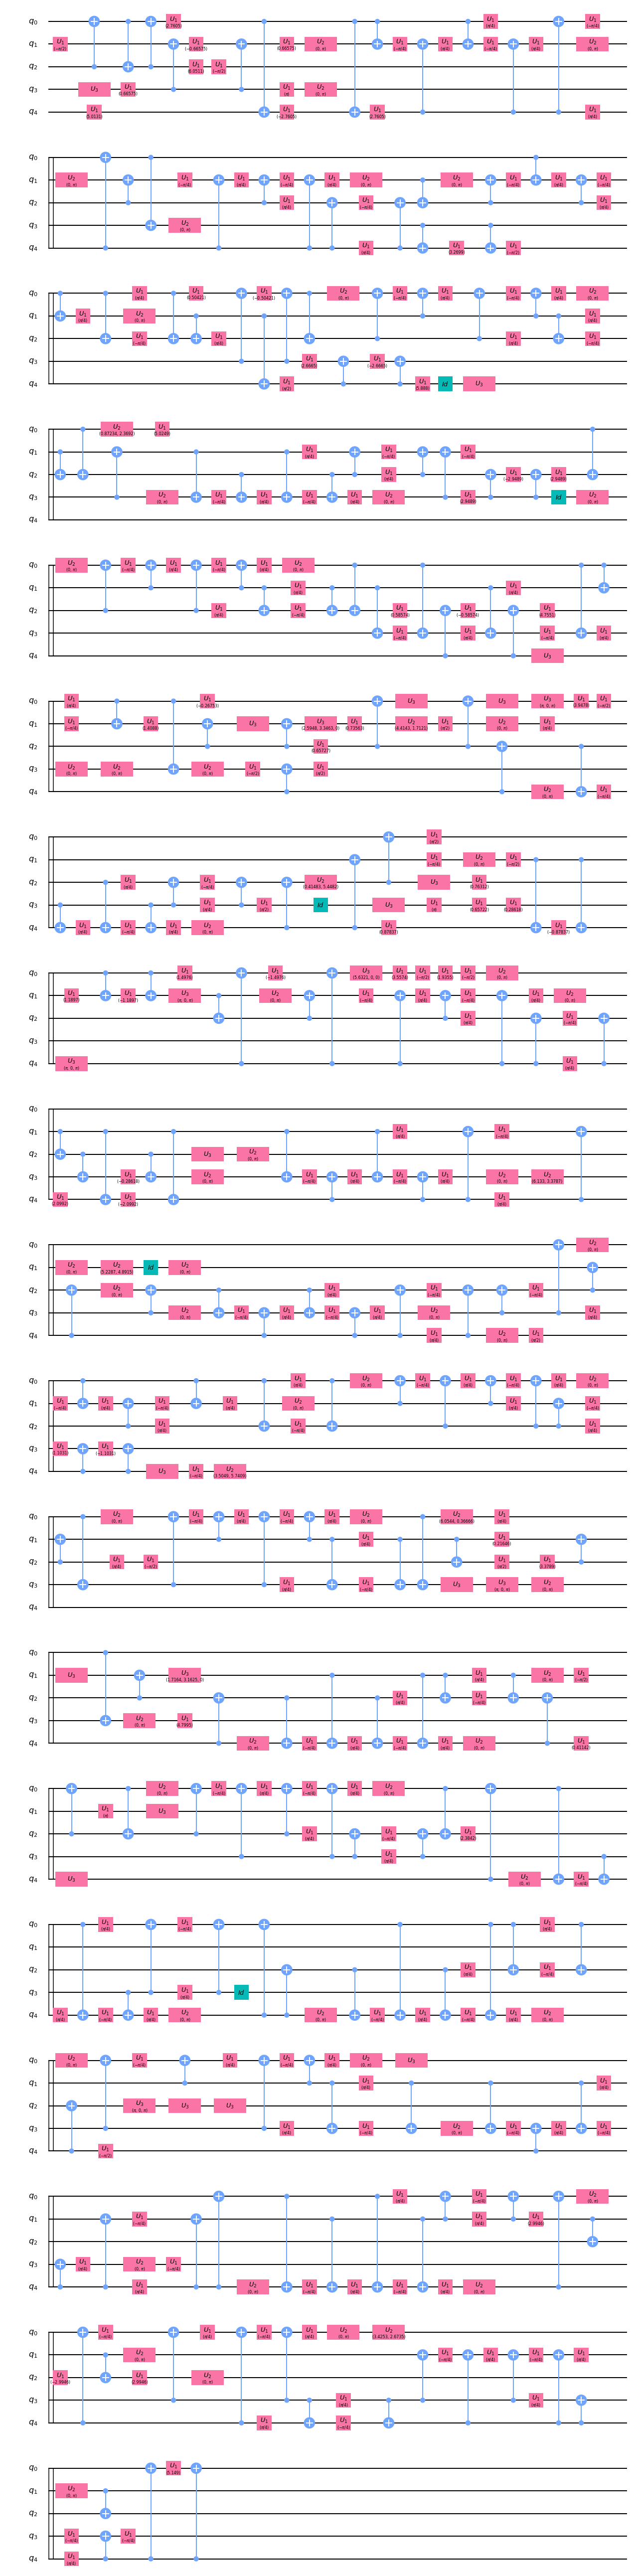

In [0]:
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u1', 'u2', 'u3', 'cx', 'id'])
pm = PassManager(pass_)
unrolled = pm.run(qc)
print('gates = ', unrolled.count_ops())
print('depth = ', unrolled.depth())
unrolled.draw(output='mpl')

## Encode the circuit

**Encode each gates to node**

1. Translate quantum circuit to QASM format
2. Print QASM line by line and encode
3. Encode mode
- control not : [gate number, [qubit number list]]
- unitary : [gate number, [qubit number list], [angle list]]

**Example**
```
gate number depends on the basis_gates list index
basis_gates = ['u1', 'u2', 'u3', 'cx', 'id']
u1 - 0, u2 - 1, u3 - 2, cx - 3, id - 4
encode cx q[0],q[1] => [3, [0, 1]]
encode u3(pi,pi,pi) q[1] => [2, [1], [3.14, 3.14, 3.14]]
```


In [0]:
# Make quantum circuit to qasm
import io
import math
qasm_str = unrolled.qasm()

In [0]:
def encode_qasm(basis_gates, qasm_str):
    qasm_list = []
    # Print qasm one line by one line and encode
    for one_line in io.StringIO(qasm_str):
        first_word = one_line.split(' ')[0]

        # Ignore meta data
        if (first_word == 'OPENQASM' or first_word == 'qreg' or first_word == 'include'):
            continue
        
        # Get information about gate and qubit
        qubit_list = [int(q[2:-1]) for q in one_line.split(' ')[1][:-2].split(',')]
        gate = first_word[:2]

        # Encode each qasm line to preferable way
        if (gate == "cx"):
            qasm_list.append([basis_gates.index(gate), qubit_list])
        elif (gate == 'u1' or gate == 'u2' or gate == 'u3'):
            angle_str = first_word[3:-1]
            # Change the pi str expression to real number
            angle_str = angle_str.replace("pi", "3.14")
            angle_str_list = angle_str.split(',')
            angle_list = [float(eval(angle_i)) for angle_i in angle_str_list]
            qasm_list.append([basis_gates.index(gate), qubit_list, angle_list])
        elif (gate == 'id'):
            qasm_list.append([basis_gates.index(gate)])
        else:
            raise "the gate be one of u1, u2, u3, cx, id"
    return qasm_list

In [0]:
basis_gates = ['u1', 'u2', 'u3', 'cx', 'id']
encode_str = encode_qasm(basis_gates, qasm_str)

In [0]:
print(encode_str)

In [0]:
print(qasm_str)